# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

#### Library

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

#### Spark Setting

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

#### Project Directory

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/,Chitra_feature_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/,airline_singleday.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/,airlines_3m_features_ext.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/,airlines_3m_full_features.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/,airlines_weather_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv,airport-timezones.csv,439779
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/,airport_edges/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/,airport_edges_1_year/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/,airport_edges_3_month/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/,airport_edges_4_year/,0


In [0]:
dbutils.fs.mv(f'{project_path}train_oversampled_Saturday_21:15.parquet', f'{project_path}train_oversampled_Saturday_2115.parquet', True)

Out[29]: True

In [0]:
display(dbutils.fs.ls(f'{project_path}train_oversampled_Saturday_2115.parquet'))

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/_SUCCESS,_SUCCESS,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/_committed_842989226410957916,_committed_842989226410957916,123624
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/_started_842989226410957916,_started_842989226410957916,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00000-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594272-1-c000.snappy.parquet,part-00000-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594272-1-c000.snappy.parquet,4079999
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00001-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594262-1-c000.snappy.parquet,part-00001-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594262-1-c000.snappy.parquet,4054606
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00002-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594261-1-c000.snappy.parquet,part-00002-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594261-1-c000.snappy.parquet,4052380
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00003-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594267-1-c000.snappy.parquet,part-00003-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594267-1-c000.snappy.parquet,4102925
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00004-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594275-1-c000.snappy.parquet,part-00004-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594275-1-c000.snappy.parquet,4085201
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00005-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594284-1-c000.snappy.parquet,part-00005-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594284-1-c000.snappy.parquet,4055751
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/train_oversampled_Saturday_2115.parquet/part-00006-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594264-1-c000.snappy.parquet,part-00006-tid-842989226410957916-48cbcf4c-11a6-46dc-9c97-9a6b91eaeed8-2594264-1-c000.snappy.parquet,4032377


#### Variables

In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = None
test_dir = None
mode = 'sample'
outcome = 'is_delayed'
run = 'full'

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

if train_dir == 'train.parquet':
  mode = 'full'
  dev_dir = "dev.parquet"
  test_dir = "test.parquet"

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

# 2. Data

### 1.1 Load the Data

In [0]:
# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data



In [0]:
train_data = loadData(train_dir, 'train_data')
display(train_data)

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_cavok,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_cavok,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_cavok,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_cavok,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_cavok,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_cavok,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_cavok,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_cavok,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure
ABE,ATL,2015,1,30,5,2015-01-30T11:35:00.000+0000,2015-01-30T14:04:00.000+0000,N603AT,DL,692.0,6,0.0,null,null,null,null,null,-11.0,2015-01-30T14:04:00.000+0000,2015-01-30T14:00:00.000+0000,2015-01-30T11:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,999.0,0.0,00792,null,011265,-2.2,-4.4,1011.9,25.0,1.5,00884,null,011265,-2.2,-4.4,1012.2,524.5,1.5,00945,null,008047,-2.2,-4.4,1013.0,999.0,0.0,00396,null,009656,-2.0,-4.4,1013.6,330.0,10.3,00732,null,016093,6.1,-0.6,1021.9,335.0,11.8,00792,null,016093,8.3,2.2,1021.1,320.0,9.3,00975,null,016093,10.6,3.9,1020.1,280.0,4.1,01067,null,016093,12.8,3.3,1019.1
ABE,ATL,2015,3,31,2,2015-03-31T16:02:00.000+0000,2015-03-31T18:10:00.000+0000,N916EV,EV,692.0,12,0.0,null,null,null,null,null,-18.0,2015-03-31T18:10:00.000+0000,2015-03-31T18:00:00.000+0000,2015-03-31T16:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.02,8,2.64,4,1.7,270.0,2.6,02134,null,016093,5.6,-3.9,1012.3,999.0,1.5,22000,null,016093,5.0,-3.9,1012.5,999.0,0.0,22000,null,016093,4.4,-3.9,1012.6,310.0,6.2,22000,null,016093,3.3,-4.4,1012.4,210.0,3.1,22000,null,016093,16.1,3.9,1018.9,999.0,0.0,22000,null,016093,13.3,6.1,1018.7,220.0,1.5,22000,null,016093,9.4,4.4,1018.3,230.0,1.5,22000,null,016093,8.9,4.4,1017.8
ABE,ATL,2015,4,24,5,2015-04-24T10:40:00.000+0000,2015-04-24T12:47:00.000+0000,N906AT,DL,692.0,6,0.0,null,null,null,null,null,4.0,2015-04-24T12:47:00.000+0000,2015-04-24T12:00:00.000+0000,2015-04-24T10:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,320.0,7.2,01280,null,016093,2.8,-6.7,1012.9,300.0,4.6,01341,null,016093,3.3,-6.1,1012.2,290.0,3.6,01402,null,016093,3.3,-6.7,1012.0,300.0,4.1,01524,null,016093,3.9,-6.7,1012.1,320.0,3.6,22000,null,016093,11.1,1.7,1016.0,320.0,4.1,22000,null,016093,12.2,1.7,1015.8,320.0,4.1,22000,null,016093,12.8,3.3,1016.0,320.0,4.1,22000,null,016093,13.3,5.0,1016.2
ABE,ATL,2015,5,7,4,2015-05-07T16:02:00.000+0000,2015-05-07T18:08:00.000+0000,N884AS,EV,692.0,12,0.0,null,null,null,null,null,-5.0,2015-05-07T18:08:00.000+0000,2015-05-07T18:00:00.000+0000,2015-05-07T16:00:00.000+0000,null,null,false,

In [0]:
train_data.count()

Out[8]: 20409767

In [0]:
# Filter out any rows that have a departure delay of greater than 15 minutes that is attributed to security delay
display(train_data.where('dep_del15 == 1') \
        .where(f.col('security_delay') > 15) \
        .where(f.greatest(*[f.col(x) for x in ['carrier_delay', 'nas_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']]) == f.col('security_delay')) 
        )


origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_cavok,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_cavok,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_cavok,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_cavok,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_cavok,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_cavok,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_cavok,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_cavok,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure


### 2.1 Preprocess and Split Data

We will be doing a time based split to make sure we have a training data, validation data to validate models and the test data,

In [0]:
def preProcessData(dff, outcome = 'is_delayed'):
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
    
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

def partitionData(dff, start_date, end_date):
    return dff.filter(f"make_date(year, month, day_of_month) between '{start_date}' and '{end_date}'")

In [0]:
if mode == 'sample':
  temp = preProcessData(train_data)
  train_data = partitionData(temp, '2015-01-01', '2015-02-28')
  dev_data = partitionData(temp, '2015-03-01', '2015-03-15')
  test_data = partitionData(temp, '2015-03-16', '2015-03-31')
else:
  train_data = preProcessData(train_data).cache()
  dev_data = preProcessData(loadData(dev_dir, 'dev'))
  test_data = preProcessData(loadData(test_dir, 'test'))

In [0]:
test_data.count()

Out[12]: 6861303

In [0]:
train_data.groupBy(outcome).count().show()

+----------+--------+
is_delayed| count|
+----------+--------+
 1| 3057117|
 0|17352650|
+----------+--------+

In [0]:
display(train_data.limit(10))

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_cavok,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_cavok,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_cavok,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_cavok,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_cavok,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_cavok,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_cavok,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_cavok,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure,time_blk,is_delayed
ACY,MYR,2017,5,10,3,2017-05-10T11:30:00.000+0000,2017-05-10T12:57:00.000+0000,N604NK,NK,466.0,7,0.0,null,null,null,null,null,-13.0,2017-05-10T12:57:00.000+0000,2017-05-10T12:00:00.000+0000,2017-05-10T11:00:00.000+0000,null,null,0,2.1560448532906333,0.6148480264501229,0.09090909090909091,1.27,10,1.0,10,1.0,999.0,0.0,3353,null,16093,283.6,279.7,1014.8,999.0,0.0,3658,null,16093,283.0,279.7,1014.4,999.0,0.0,22000,null,16093,284.1,279.1,1014.2,999.0,0.0,22000,null,16093,285.8,277.4,1014.3,270.0,4.1,22000,null,16093,293.0,288.0,1013.8,250.0,4.1,22000,null,16093,293.6,287.4,1013.2,260.0,5.7,22000,null,16093,294.1,288.0,1013.2,null,null,null,null,null,null,null,null,1,0
AEX,ATL,2017,1,28,6,2017-01-28T12:00:00.000+0000,2017-01-28T14:49:00.000+0000,N859AS,EV,500.0,6,0.0,null,null,null,null,null,-40.0,2017-01-28T14:49:00.000+0000,2017-01-28T14:00:00.000+0000,2017-01-28T12:00:00.000+0000,null,null,0,9.031150214803475,0.3143358531845712,0.3333333333333333,1.05,8,3.4,6,3.38,300.0,2.6,22000,null,16093,276.9,273.6,1025.0,280.0,1.5,22000,null,16093,276.9,274.1,1025.3,220.0,2.1,22000,null,16093,278.0,274.1,1024.9,280.0,2.6,22000,null,16093,278.6,274.1,1025.1,280.0,4.6,22000,null,16093,273.6,268.6,1018.1,270.0,4.1,7620,null,16093,274.1,268.6,1018.3,270.0,4.6,7620,null,16093,274.1,268.6,1018.1,260.0,3.6,7620,null,16093,274.7,268.6,1017.9,1,0
AMA,IAH,2018,2,28,3,2018-02-28T23:00:00.000+0000,2018-03-01T00:44:00.000+0000,N12530,EV,517.0,17,0.0,null,null,null,null,null,-5.0,2018-03-01T00:44:00.000+0000,2018-03-01T00:00:00.000+0000,2018-02-28T23:00:00.000+0000,null,null,0,6.074249511495245,0.4331614607602674,0.16666666666666666,1.13,11,2.75,3,2.71,250.0,6.2,22000,null,16093,293.6,260.8,1003.0,250.0,6.2,22000,null,16093,293.6,260.8,1003.6,250.0,7.7,22000,null,16093,293.6,261.3,1004.9,250.0,9.3,22000,null,16093,293.0,263.6,1005.8,170.0,8.2,1219,null,16093,300.8,291.3,1009.9,170.0,7.7,1128,null,16093,301.3,291.9,1010.3,170.0,9.3,7620,null,16093,300.8,291.9,1011.4,190.0,5.1,975,null,16093,299.7,292.4,1012.7,2,0
ANC,SEA,2015,1,3,6,2015-01-03T18:45:00.000+0000,2015-01-03T23:05:00.000+0000,N435AS,AS,1448.0,9,0.0,null,null,null,null,null,-18.0,2015-01-03T23:05:00.000+0000,2015-01-03T23:00:00

### 1.2 Get the Features and Target Vars from Data

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher, SQLTransformer
from pyspark.ml import Pipeline

def createStages(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumns = ['origin', 'destination', 'month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  if run != 'basic':
    categoricalColumns += ['equipment_delayed']
  for categoricalCol in categoricalColumns:
      stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep")
      encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"], handleInvalid='keep')
      stages += [stringIndexer, encoder]

  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_')) and 'cavok' not in x]

  for i in numericCols:
    imputer = Imputer(inputCol=i, outputCol=i+"_Imputed", strategy='mean')
    assembler = VectorAssembler(inputCols=[i+"_Imputed"],outputCol=i+"_Vect", handleInvalid='keep')
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    stages += [imputer, assembler, scaler]
    #stages += [imputer, assembler]

  print(numericCols)

  assemblerInputs = [c + "classVec" for c in categoricalColumns] + [c + "_Scaled" for c in numericCols]
  assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
  #assembler = FeatureHasher(inputCols=assemblerInputs, outputCol="features")
  stages += [assembler]
  return stages

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages


In [0]:
from pyspark.ml import PipelineModel
pipelineModel = None

if not loadPipelineFromFile:
  # Create the pipeline and fit to the training data
  stages = createStages2(train_data, outcome, run)
  pipeline = Pipeline(stages = stages)
  pipelineModel = pipeline.fit(train_data)
  if savePipeline:
    filename = f'{save_path}/pipeline-model'
    pipelineModel.save(filename)
else:
  pipelineModel = PipelineModel.load(f'{save_path}/pipeline-model')

In [0]:
# Transform the train, dev and test data with the pipeline
def transformData (d, pl_model, cols):
  return pl_model.transform(d).select(cols)

selectedCols = ['label', 'features']

# Transform the training, dev and test data
train = transformData(train_data, pipelineModel, selectedCols).cache()
dev = transformData(dev_data, pipelineModel, selectedCols)
#test = transformData(test_data, pipelineModel, selectedCols)

train.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)

In [0]:
smote_train_dir = 'train_smote2.parquet'
smote_train = loadData(smote_train_dir, 'smote_train').cache()

In [0]:
display(smote_train.limit(10))

distance,numeric_Scaled,monthclassVec,day_of_monthclassVec,day_of_weekclassVec,op_carrierclassVec,dep_blkclassVec,equipment_delayedclassVec,label,features
425.0,"Map(vectorType -> dense, length -> 65, values -> List(0.6976370760780825, 1.9361360329041681, 0.19867603322136868, 1.0471154350840828, 2.1850589276825017, 0.028920379102747577, 0.33818657828512166, 0.028004364109937768, 0.6258970378311947, 0.7142693921989215, 0.07536858596694662, 0.05044754628490749, 0.2861773686727239, 16.698994911096367, 13.48513037014741, 1.4757435145357594, 1.5470561056518726, 0.0932425492567567, 0.03144154325087893, 0.20909045676725427, 16.638239354315374, 13.327228898297815, 1.4761669399592385, 0.756270388520184, 0.09457338116064362, 0.1002647798731767, 0.20666974683274675, 16.376836802628866, 13.145385004068693, 1.4809632955578784, 2.095342814237511, 0.09635485813364006, 0.17197317794825412, 0.33193519854377834, 16.150621406849137, 13.025204567625105, 1.4792459107375724, 1.0091027626061357, 0.24473862420547118, 0.050494857297861705, 1.5868235253349392, 17.300495920594006, 13.76121068702162, 1.492995256254572, 0.9604722996422729, 0.16823293328800143, 0.03775886452586595, 1.4788249875284438, 16.903571717432804, 13.54301458130975, 1.4939665713189434, 0.8973103494748425, 0.22693090319872813, 0.0344617427832194, 1.400938332556053, 16.64431061599722, 13.403790234519672, 1.4910768421584715, 0.8552842310151383, 0.2434133118347479, 0.02813330460709018, 0.9519832902116925, 16.270733174470415, 13.158829029752162, 1.4910457644911888))","Map(vectorType -> sparse, length -> 13, indices -> List(11), values -> List(1.0))","Map(vectorType -> sparse, length -> 32, indices -> List(6), values -> List(1.0))","Map(vectorType -> sparse, length -> 8, indices -> List(6), values -> List(1.0))","Map(vectorType -> sparse, length -> 20, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 20, indices -> List(8), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 161, indices -> List(11, 19, 51, 58, 81, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6976370760780825, 1.9361360329041681, 0.19867603322136868, 1.0471154350840828, 2.1850589276825017, 0.028920379102747577, 0.33818657828512166, 0.028004364109937768, 0.6258970378311947, 0.7142693921989215, 0.07536858596694662, 0.05044754628490749, 0.2861773686727239, 16.698994911096367, 13.48513037014741, 1.4757435145357594, 1.5470561056518726, 0.0932425492567567, 0.03144154325087893, 0.20909045676725427, 16.638239354315374, 13.327228898297815, 1.4761669399592385, 0.756270388520184, 0.09457338116064362, 0.1002647798731767, 0.20666974683274675, 16.376836802628866, 13.145385004068693, 1.4809632955578784, 2.095342814237511, 0.09635485813364006, 0.17197317794825412, 0.33193519854377834, 16.150621406849137, 13.025204567625105, 1.4792459107375724, 1.0091027626061357, 0.24473862420547118, 0.050494857297861705, 1.5868235253349392, 17.300495920594006, 13.76121068702162, 1.492995256254572, 0.9604722996422729, 0.16823293328800143, 0.03775886452586595, 1.4788249875284438, 16.903571717432804, 13.54301458130975, 1.4939665713189434, 0.8973103494748425, 0.22693090319872813, 0.0344617427832194, 1.400938332556053, 16.64431061599722, 13.403790234519672, 1.4910768421584715, 0.8552842310151383, 0.2434133118347479, 0.02813330460709018, 0.9519832902116925, 16.270733174470415, 13.158829029752162, 1.4910457644911888))"
349.0,"Map(vectorType -> dense, length -> 65, values -> List(0.5728831518852959, 3.168956703249413, 0.4225702269847841, 0.42660258466388556, 2.1850589276825017, 0.20244265371923303, 0.8116477878842919, 

In [0]:
smote_train.groupBy('label').count().show()

+-----+--------+
label| count|
+-----+--------+
 0.0|17352650|
 1.0|14125509|
+-----+--------+

# 2. Classifiers

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol, maxIter = 20, maxDepth = 8, maxBins = 60) #based on CV grid search 20,8,60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = True):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

# 3. GBTClassifier on SMOTE training data

In [0]:
# To transform the smote training set
def createStages3(dff, outcome):
  stages = []
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]
  
  categoricals = [c for c in dff.columns if c.endswith('classVec')]
  print(categoricals)
  
  scaler = StandardScaler(inputCol = 'numeric_Scaled', outputCol = 'smote_Scaled')
  stages += [scaler]
  feature_assembler = VectorAssembler(inputCols=[c for c in categoricals] + ["smote_Scaled"], outputCol="features")
  
  return stages

# Create the pipeline and fit to the training data
stages = createStages3(smote_train, 'label')
pipeline = Pipeline(stages = [stages, gbt])
model = pipeline.fit(smote_train)

Confusion matrix:
[[1893837. 28613.]
 [ 323347. 18671.]]

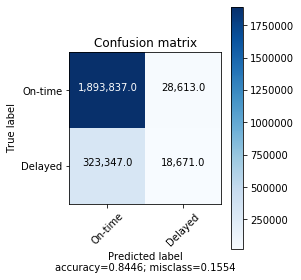

Summary Stats
Precision = 0.3948693003975975
Recall = 0.05459069405703793
F1 Score = 0.09592039085337346
Class 0 precision = 0.8541632088270527
Class 0 recall = 0.9851163879424693
Class 0 F1 Measure = 0.914977990807883
Class 1 precision = 0.3948693003975975
Class 1 recall = 0.05459069405703793
Class 1 F1 Measure = 0.09592039085337346
Weighted recall = 0.8445727649938087
Weighted precision = 0.7847929267240485
Weighted F(1) Score = 0.7912701520478558
Weighted F(0.5) Score = 0.7715049077932301
Weighted false positive rate = 0.8048656829943015

In [0]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt = GBTClassifier()
model = gbt.fit(smote_train)

predictions = predictAndEvaluate(dev, model)

In [0]:
smote_train_dir = 'train_oversampled_Tuesday_3-15.parquet'
dev_dir = 'dev_transformed_Tuesday_2-59.parquet'
smote_train = loadData(smote_train_dir, 'smote_train').cache()
dev_data = loadData(dev_dir, 'dev_data').cache()

In [0]:
smote_train.groupBy('label').count().show()

+-----+--------+
label| count|
+-----+--------+
 1.0| 9171351|
 0.0|17352650|
+-----+--------+

In [0]:
#partition the train_sample into an 80% for train and 20% for validation so that early stopping can be enabled
def createTrainValSplit(dff, ratio =0.8):
    # do a split within training data
    t = dff.sample(fraction = ratio, seed=SEED)
    v = dff.subtract(t)
    
    # add validation column
    t = t.withColumn('validation', f.lit('False').cast(BooleanType()))
    v = v.withColumn('validation', f.lit('True').cast(BooleanType()))
    return t.union(v)
  
# do a split within training data
smote_train = createTrainValSplit(smote_train).cache()

In [0]:
display(smote_train.limit(10))

label,originIndex,destinationIndex,hash_vector,numeric_scaled,features,monthclassVec,day_of_monthclassVec,day_of_weekclassVec,op_carrierclassVec,dep_blkclassVec,equipment_delayedclassVec,validation
0.0,54.0,6.0,"Map(vectorType -> dense, length -> 67, values -> List(54.0, 6.0, 0.5384116728320262, 1.6455928699185318, 0.4225702269847839, 0.4266025846638852, 2.2270792916763953, 0.20244265371923303, 1.0630821569571434, 0.05600872821987558, 0.5418213163314813, 3.452686078097044, 0.09331348738764814, 2.274274627598289, 1.4307090382262029, 18.532254135031952, 13.33311617324756, 1.493206183480326, 3.3992134520811303, 0.1111738087292098, 2.2679145951453648, 1.3939075065266882, 18.368375113260484, 13.230303597219295, 1.496317366922448, 0.369732189943201, 0.05456156605421747, 2.2623847766255256, 1.377769774556501, 17.978918663755604, 13.064033877359854, 1.5022239873824719, 3.325254124580259, 0.0, 2.2574044838076324, 1.3278233035458673, 17.601836663696446, 12.94459718588151, 1.5003292108805752, 3.4761850339432074, 0.07670912101962533, 2.2764075011331086, 1.5868235253349392, 19.765658159828813, 13.960204834887334, 1.500434196245876, 0.8575645532520298, 0.09508817968452256, 2.2696585234127085, 1.4788249875284438, 19.232755393409477, 13.738491105614388, 1.5047027319272832, 0.27088614323768845, 0.095164572309144, 2.2631592275547066, 1.4009383325560532, 18.803934252210293, 13.566469556968775, 1.504792006073547, 0.26832446463220033, 0.11262406965488336, 2.258878472102131, 1.359988201453775, 18.21537124027883, 13.342665611785469, 1.5062666079637774))","Map(vectorType -> dense, length -> 65, values -> List(0.5384116728320262, 1.6455928699185318, 0.4225702269847839, 0.4266025846638852, 2.2270792916763953, 0.20244265371923303, 1.0630821569571434, 0.05600872821987558, 0.5418213163314813, 3.452686078097044, 0.09331348738764814, 2.274274627598289, 1.4307090382262029, 18.532254135031952, 13.33311617324756, 1.493206183480326, 3.3992134520811303, 0.1111738087292098, 2.2679145951453648, 1.3939075065266882, 18.368375113260484, 13.230303597219295, 1.496317366922448, 0.369732189943201, 0.05456156605421747, 2.2623847766255256, 1.377769774556501, 17.978918663755604, 13.064033877359854, 1.5022239873824719, 3.325254124580259, 0.0, 2.2574044838076324, 1.3278233035458673, 17.601836663696446, 12.94459718588151, 1.5003292108805752, 3.4761850339432074, 0.07670912101962533, 2.2764075011331086, 1.5868235253349392, 19.765658159828813, 13.960204834887334, 1.500434196245876, 0.8575645532520298, 0.09508817968452256, 2.2696585234127085, 1.4788249875284438, 19.232755393409477, 13.738491105614388, 1.5047027319272832, 0.27088614323768845, 0.095164572309144, 2.2631592275547066, 1.4009383325560532, 18.803934252210293, 13.566469556968775, 1.504792006073547, 0.26832446463220033, 0.11262406965488336, 2.258878472102131, 1.359988201453775, 18.21537124027883, 13.342665611785469, 1.5062666079637774))","Map(vectorType -> sparse, length -> 161, indices -> List(1, 16, 47, 56, 80, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5384116728320262, 1.6455928699185318, 0.4225702269847839, 0.4266025846638852, 2.2270792916763953, 0.20244265371923303, 1.0630821569571434, 0.05600872821987558, 0.5418213163314813, 3.452686078097044, 0.09331348738764814, 2.274274627598289, 1.4307090382262029, 18.532254135031952, 13.33311617324756, 1.493206183480326, 3.3992134520811303, 0.1111738087292098, 2.2679145951453648, 1.3939075065266882, 18.368375113260484, 13.230303597219295, 1.496317366922448, 0.369732189943201, 0.05456156605421747, 2.2623847766255256, 1.377769774556501, 17.978918663755604, 13.064033877359854, 1.5022239873824719, 3.325254124580259, 2.2574044838076324, 1.3278233035458673, 17.6018

Test Area Under ROC: 0.5718383026099481
Test Area Under PR: 0.2874598956820152
Accuracy = 0.852642 
Test Error = 0.147358 
Confusion matrix:
[[1946204. 4016.]
 [ 333974. 9478.]]

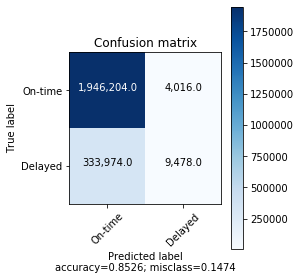

Summary Stats
Precision = 0.7023862457388469
Recall = 0.02759628710853336
F1 Score = 0.05310607206692329
Class 0 precision = 0.8535316102514804
Class 0 recall = 0.9979407451467014
Class 0 F1 Measure = 0.9201044440735836
Class 1 precision = 0.7023862457388469
Class 1 recall = 0.02759628710853336
Class 1 F1 Measure = 0.05310607206692329
Weighted recall = 0.8526424004827194
Weighted precision = 0.8308992645051867
Weighted F(1) Score = 0.7902810321548649
Weighted F(0.5) Score = 0.7652093206603044
Weighted false positive rate = 0.8271053682274847

In [0]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt = GBTClassifier(stepSize = 0.064, maxIter = 14, maxDepth = 4, validationIndicatorCol = 'validation', validationTol = 0.01)
bestModel = gbt.fit(smote_train)
predictions = predictAndEvaluate(dev_data, bestModel)

In [0]:
smote_train_dir = 'train_smote.parquet'
smote_train = loadData(smote_train_dir, 'smote_train').cache()

In [0]:
smote_train.groupBy('label').count().show()

+-----+--------+
label| count|
+-----+--------+
 0.0|17352650|
 1.0|10120578|
+-----+--------+

Confusion matrix:
[[1907431. 15019.]
 [ 330554. 11464.]]

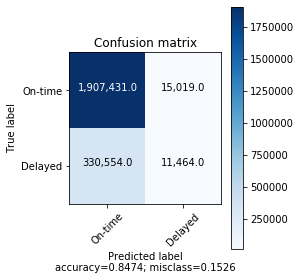

Summary Stats
Precision = 0.4328814711324246
Recall = 0.03351870369395763
F1 Score = 0.06221964119500354
Class 0 precision = 0.8522983844842571
Class 0 recall = 0.9921875731488465
Class 0 F1 Measure = 0.916938252850964
Class 1 precision = 0.4328814711324246
Class 1 recall = 0.03351870369395763
Class 1 F1 Measure = 0.06221964119500354
Weighted recall = 0.8473932950255867
Weighted precision = 0.7889509961039546
Weighted F(1) Score = 0.7878442890054389
Weighted F(0.5) Score = 0.7638920923843739
Weighted false positive rate = 0.8216870181827824

In [0]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt = GBTClassifier()
bestModel = gbt.fit(smote_train)
predictions = predictAndEvaluate(dev, bestModel)